In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.special import rel_entr
import networkx as nx
from sklearn.metrics import r2_score

import os
import json

In [2]:
pkn_path = "/dccstor/ipc1/CAR/BFN/LiverDREAM_PKN_without_logic.gexf"
network = nx.read_gexf(pkn_path)

In [3]:
child_dict = {}
for n in network.nodes():
    child_dict[n] = [c for c in network.successors(n)]

    
child_dict = {k: f"{k}_inhbits_{'_'.join(v)}" for k, v in child_dict.items()}
child_dict

{'tgfa': 'tgfa_inhbits_ras_pi3k',
 'ras': 'ras_inhbits_mek12_pi3k',
 'pi3k': 'pi3k_inhbits_akt_map3k1',
 'igf1': 'igf1_inhbits_pi3k',
 'tnfa': 'tnfa_inhbits_pi3k_jnk12_map3k7',
 'jnk12': 'jnk12_inhbits_',
 'map3k7': 'map3k7_inhbits_p38_hsp27_mkk4_ikk',
 'il1a': 'il1a_inhbits_map3k1_map3k7',
 'map3k1': 'map3k1_inhbits_ikk_mkk4',
 'mek12': 'mek12_inhbits_erk12',
 'erk12': 'erk12_inhbits_hsp27',
 'hsp27': 'hsp27_inhbits_',
 'akt': 'akt_inhbits_ikk',
 'ikk': 'ikk_inhbits_ikb',
 'mkk4': 'mkk4_inhbits_p38_jnk12',
 'p38': 'p38_inhbits_hsp27',
 'ikb': 'ikb_inhbits_'}

In [4]:
folder = "/dccstor/ipc1/CAR/BFN/Model/Perturbation_Liver/Output/"
config_folder = "/dccstor/ipc1/CAR/BFN/Model/Perturbation_Liver/Configs/"

In [5]:
n_repeats = 5
n_settings = 17

perturb_data = []
unperturb_data = []
p_settings = np.empty(0)
p_repeats = np.empty(0)
up_settings = np.empty(0)
p_nodes = np.empty(0)
up_repeats = np.empty(0)
up_nodes = np.empty(0)

for i in range(n_settings):
    for j in range(n_repeats):
        perturb = pd.read_csv(f"{folder}param_{i}_repeat_{j}_perturbed.csv", index_col=1)
        perturb = perturb.rename(columns={"Unnamed: 0":"model"})
        perturb_data.append(perturb)
        
        unperturb = pd.read_csv(f"{folder}param_{i}_repeat_{j}_unperturbed.csv", index_col=1)
        unperturb = unperturb.rename(columns={"Unnamed: 0":"model"})
        unperturb_data.append(unperturb)
        
        with open(f"{config_folder}param_{i}_repeat_{j}_config.json", "r") as f:
            config = json.load(f)
        f.close()
        node = config["inhibited_node"]
        
        p_settings = np.hstack([p_settings, [i]*len(perturb)])
        p_repeats = np.hstack([p_repeats, [j]*len(perturb)])
        p_nodes = np.hstack([p_nodes, [node]*len(perturb)])
    
        up_settings = np.hstack([up_settings, [i]*len(unperturb)])
        up_repeats = np.hstack([up_repeats, [j]*len(unperturb)])
        up_nodes = np.hstack([up_nodes, [node]*len(unperturb)])

In [6]:
perturb_data = pd.concat(perturb_data)
unperturb_data = pd.concat(unperturb_data)
perturb_data["setting"] = p_settings
perturb_data["repeat"] = p_repeats
perturb_data["node"] = p_nodes
unperturb_data["setting"] = up_settings
unperturb_data["repeat"] = up_repeats
unperturb_data["node"] = up_nodes


In [7]:
setting_to_node = perturb_data[["setting", "node"]].drop_duplicates().set_index("setting").to_dict()["node"]
output_markers = [c for c in perturb_data.columns if c not in ["setting", "node", "model", "repeat"]]
markers = [
        "mek12",
        "erk12",
        "mkk4",
        "jnk12",
        "ikk",
        "ikb",
        "ras",
        "map3k7",
        "igf1",
        "pi3k",
        "il1a",
        "map3k1",
        "tgfa",
        "tnfa",
        "akt",
        "p38",
        "hsp27",
    ]

In [8]:
def compute_MSE(data, true_model_name: str):
    true = data[data["model"]==true_model_name]
    true = true.drop(["model", "setting", "node"], axis=1)
    true["repeat"] = 0 # So that repeat doesn't get lost when x-true. This doesn't cancel out the different repeats
    data = data.groupby("model").apply(lambda x: ((x-true)**2).groupby("repeat").mean())
    data = data.drop(["model", "setting", "node"], axis=1)
    data = data.reset_index("model", drop=False)
    
    return data

def compute_KL(data, true_model_name: str, markers=output_markers):
    true = data[data["model"]==true_model_name]
    data = data.groupby("model").apply(lambda x: pd.Series([rel_entr(true[m], x[m]).sum() for m in markers]))
    data.columns=markers
    data[data==np.inf] = 0
    data = data.reset_index(drop=False)
    
    return data

def compute_R2(data, true_model_name: str, markers=output_markers):
    true = data[data["model"]==true_model_name]
    data = data.groupby("model").apply(lambda x: pd.Series([r2_score(true[m], x[m]) for m in markers]))
    data.columns=markers
    data[data==np.inf] = 0
    data = data.reset_index(drop=False)
    
    return data

In [9]:
perturb_MSE = perturb_data.groupby("setting").apply(compute_MSE, true_model_name="teacher_k_inhibition_true").reset_index()
unperturb_MSE = unperturb_data.groupby("setting").apply(compute_MSE, true_model_name="teacher_no_pertrub_true").reset_index()

perturb_KL = perturb_data.groupby(["setting", "repeat"]).apply(compute_KL, true_model_name="teacher_k_inhibition_true").reset_index().drop("level_2", axis=1)
unperturb_KL = unperturb_data.groupby(["setting", "repeat"]).apply(compute_KL, true_model_name="teacher_no_pertrub_true").reset_index().drop("level_2", axis=1)

perturb_R2 = perturb_data.groupby(["setting", "repeat"]).apply(compute_R2, true_model_name="teacher_k_inhibition_true").reset_index().drop("level_2", axis=1)
unperturb_R2 = unperturb_data.groupby(["setting", "repeat"]).apply(compute_R2, true_model_name="teacher_no_pertrub_true").reset_index().drop("level_2", axis=1)


perturb_MSE["inhibited_node"] = [setting_to_node[s] for s in perturb_MSE["setting"]]
unperturb_MSE["inhibited_node"] = [setting_to_node[s] for s in unperturb_MSE["setting"]]
perturb_KL["inhibited_node"] = [setting_to_node[s] for s in perturb_KL["setting"]]
unperturb_KL["inhibited_node"] = [setting_to_node[s] for s in unperturb_KL["setting"]]
perturb_R2["inhibited_node"] = [setting_to_node[s] for s in perturb_R2["setting"]]
unperturb_R2["inhibited_node"] = [setting_to_node[s] for s in unperturb_R2["setting"]]

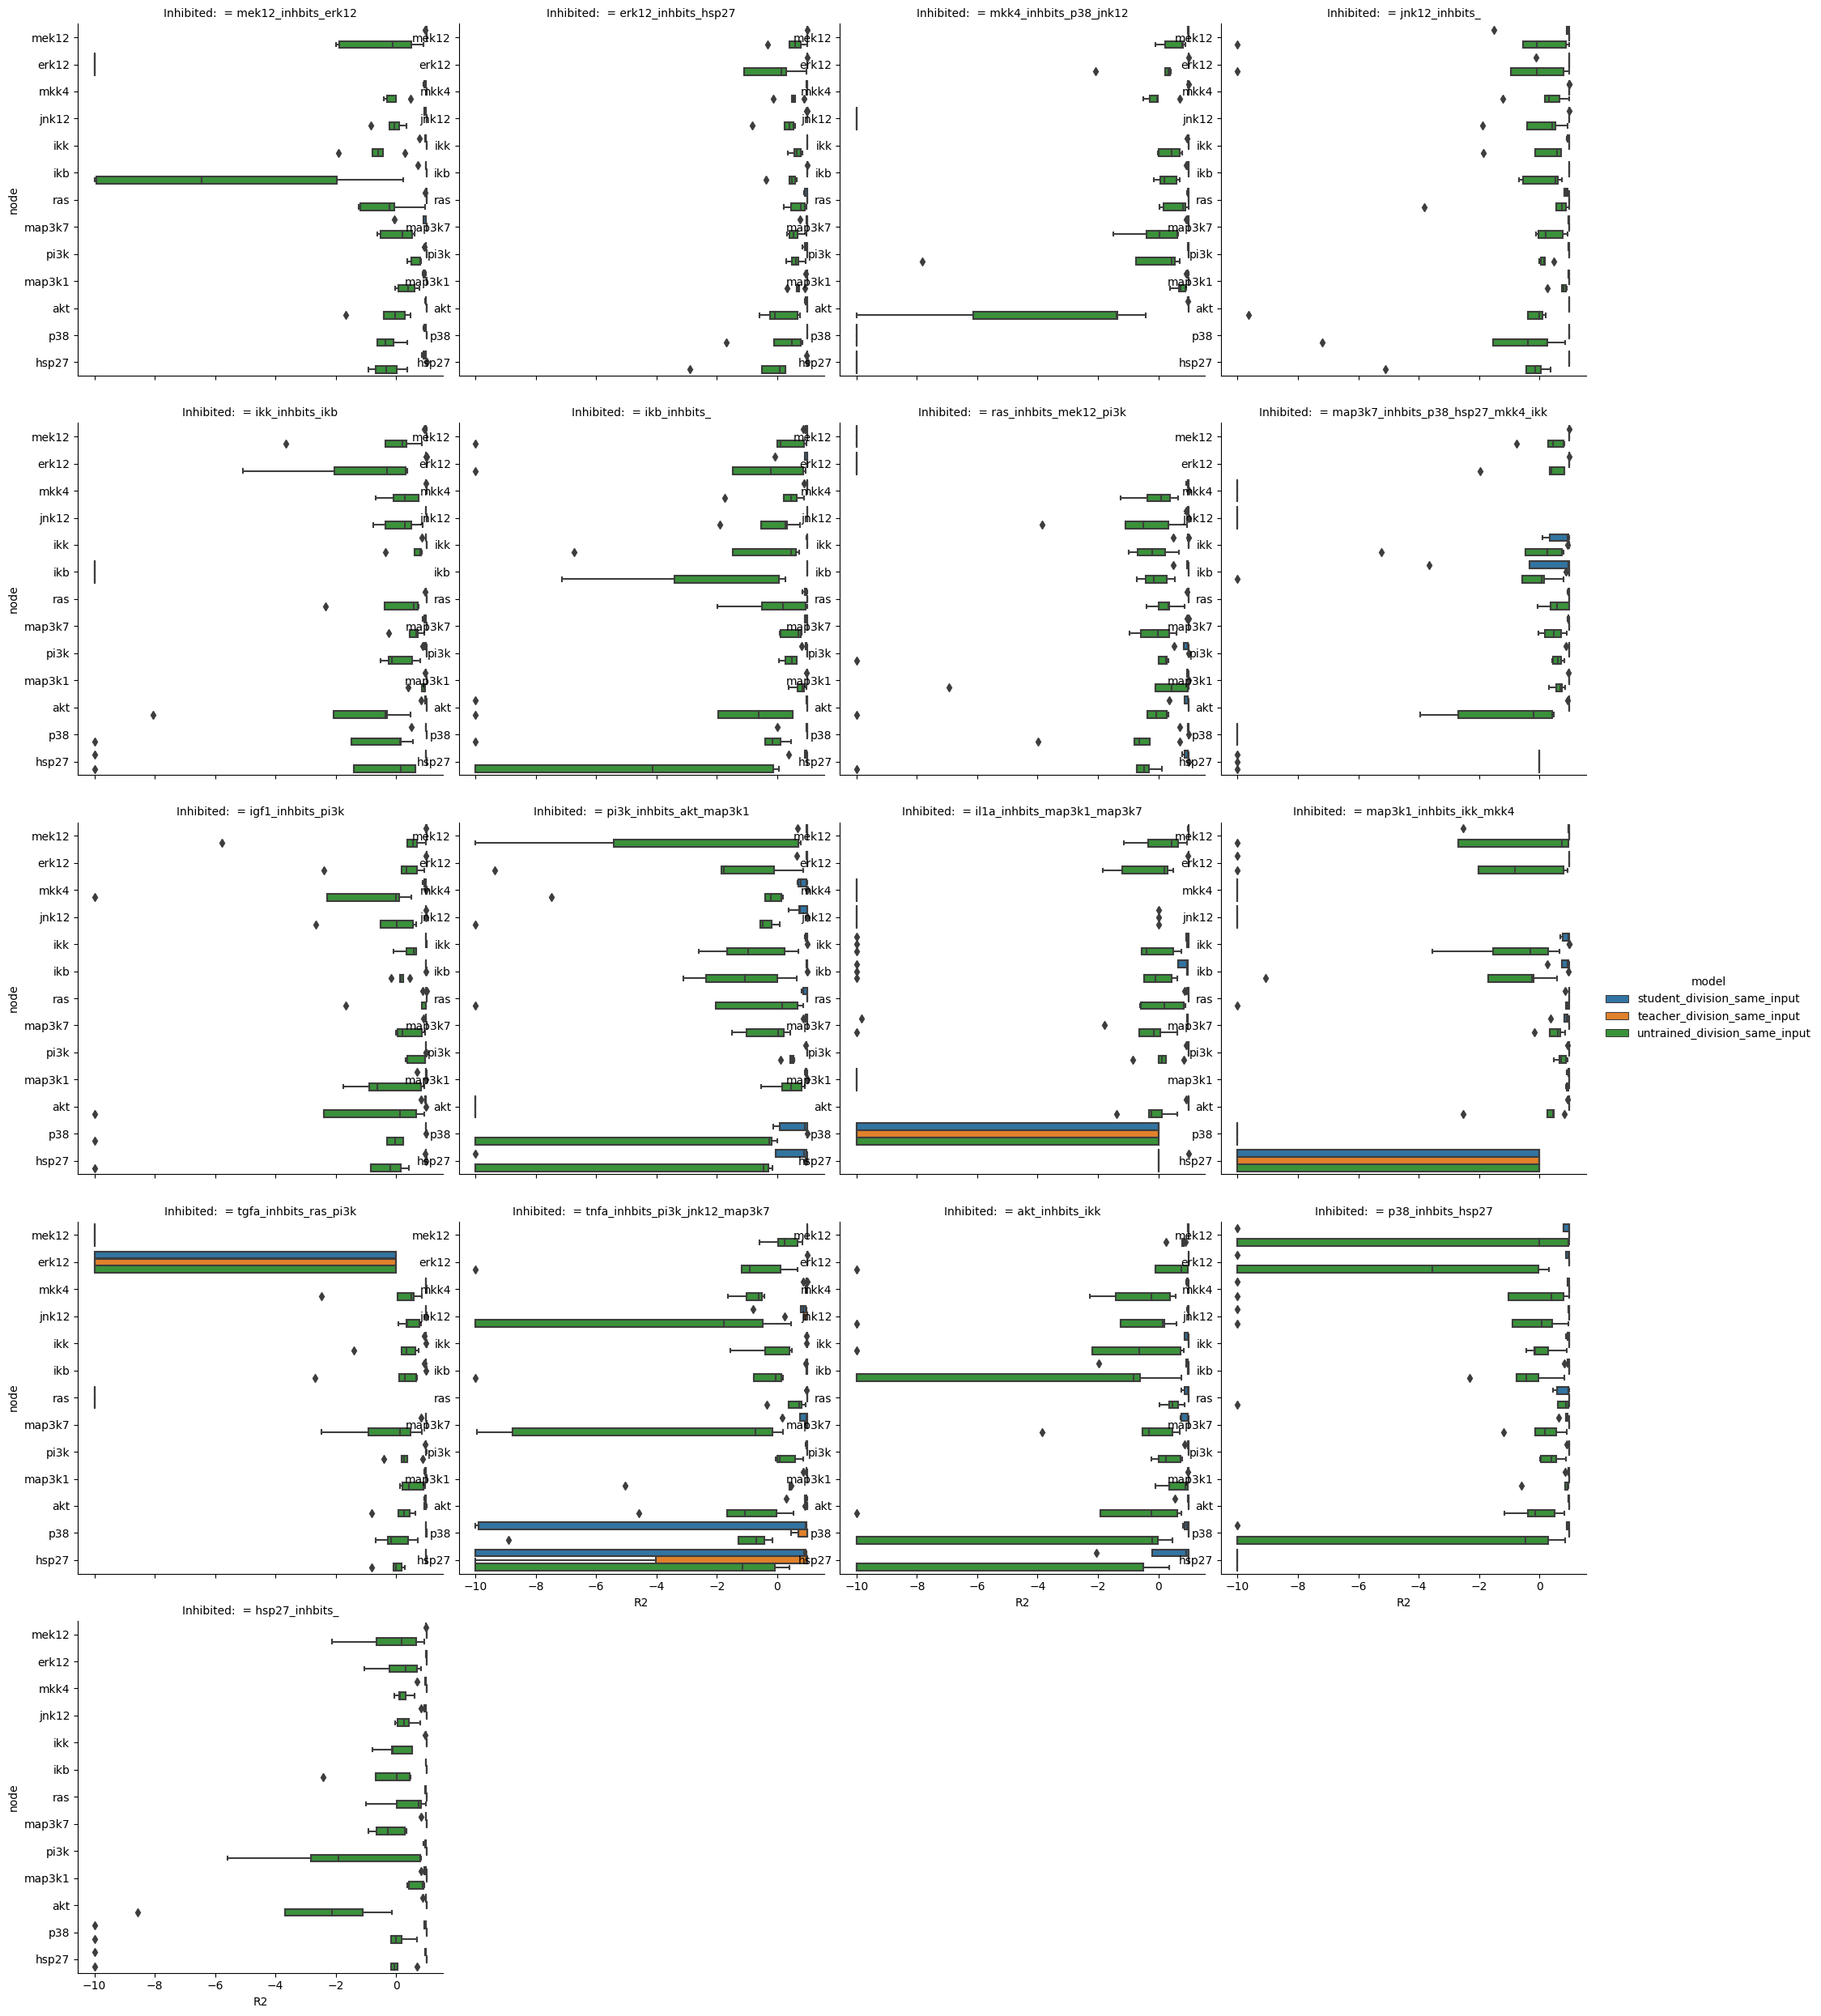

In [50]:
plt_data = perturb_R2[["same" in m for m in perturb_R2["model"]]]
plt_data = plt_data.melt(id_vars=["setting", "repeat", "model", "inhibited_node"], var_name="node", value_name="R2")
plt_data["Inhibited: "] = plt_data["inhibited_node"].map(child_dict)
temp = plt_data.copy()
temp.loc[temp["R2"]<-10, "R2"] = -10
g = sns.catplot(data=temp, y="node", x="R2", col="Inhibited: ", col_wrap=4, kind="box", hue="model")#.set(xscale='symlog')
for ax in g.axes.flatten():
    ax.tick_params(labelleft=True)

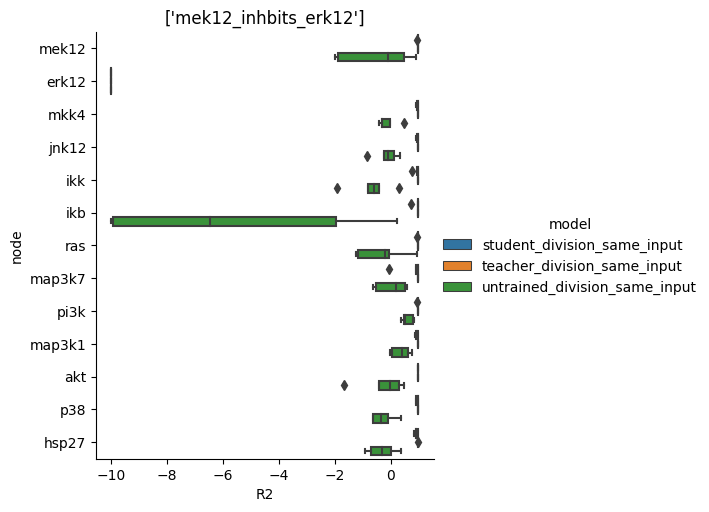

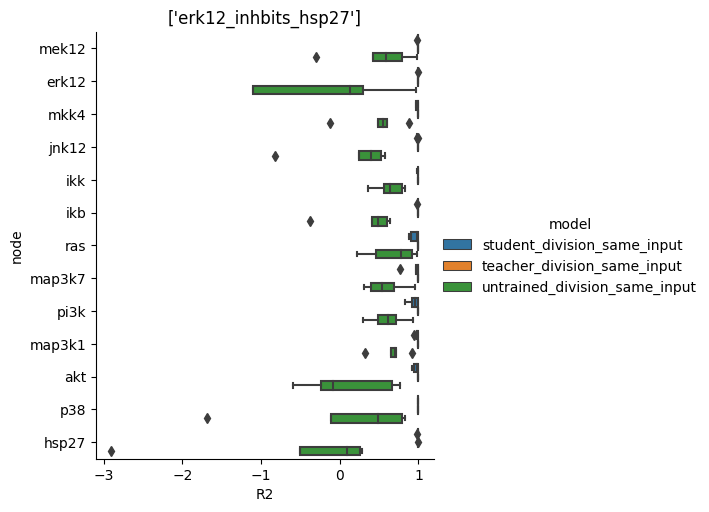

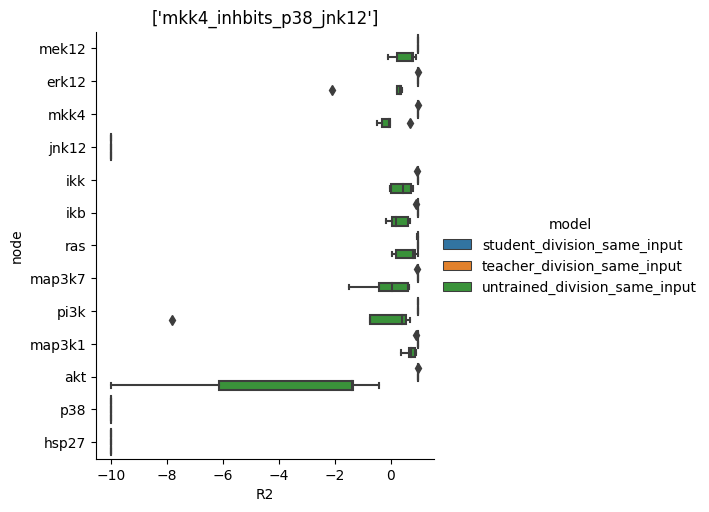

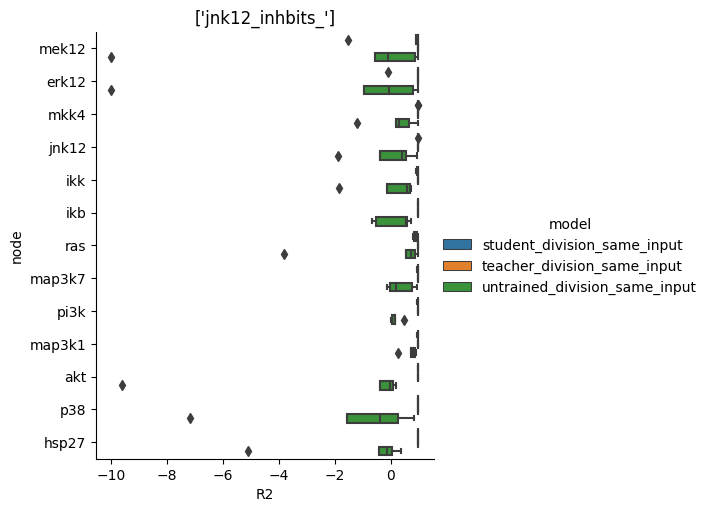

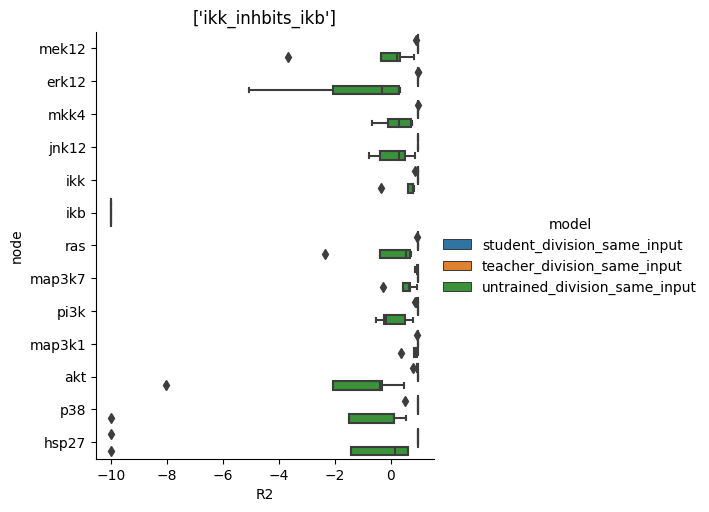

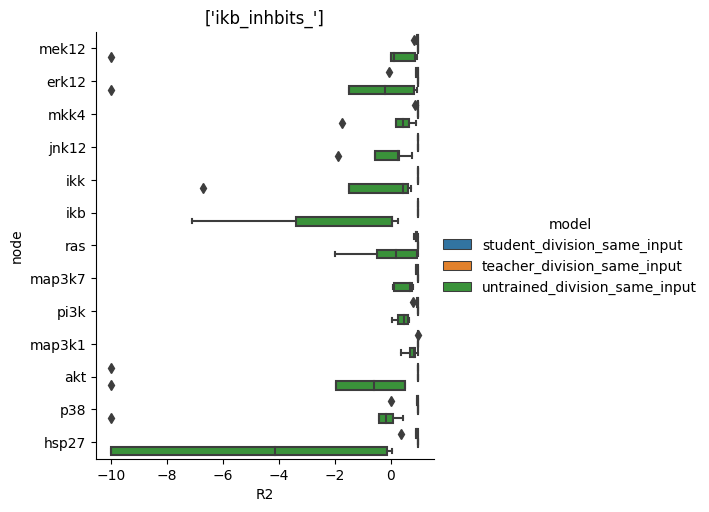

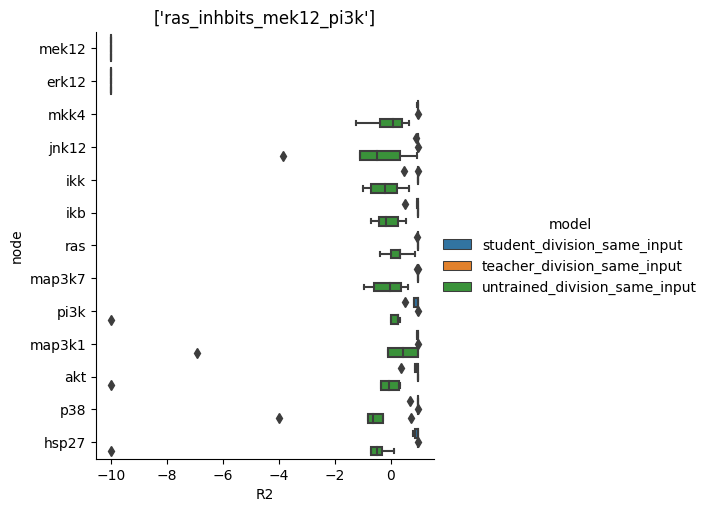

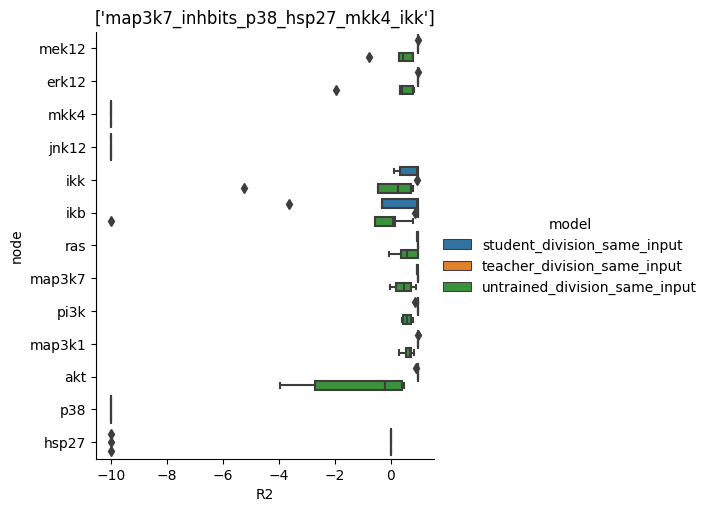

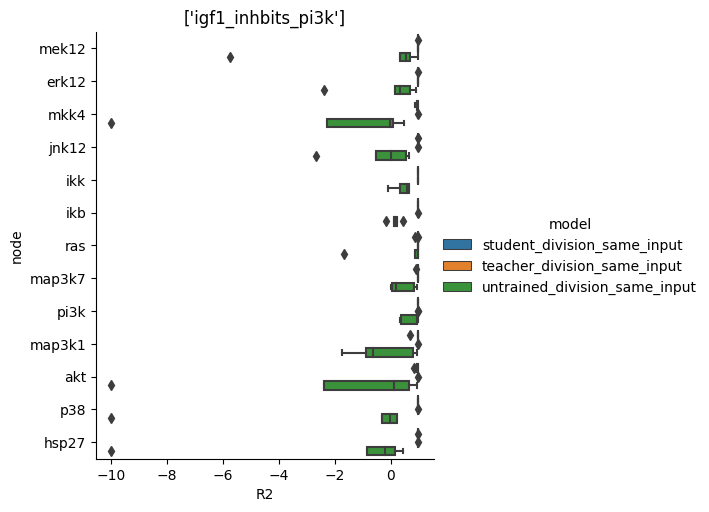

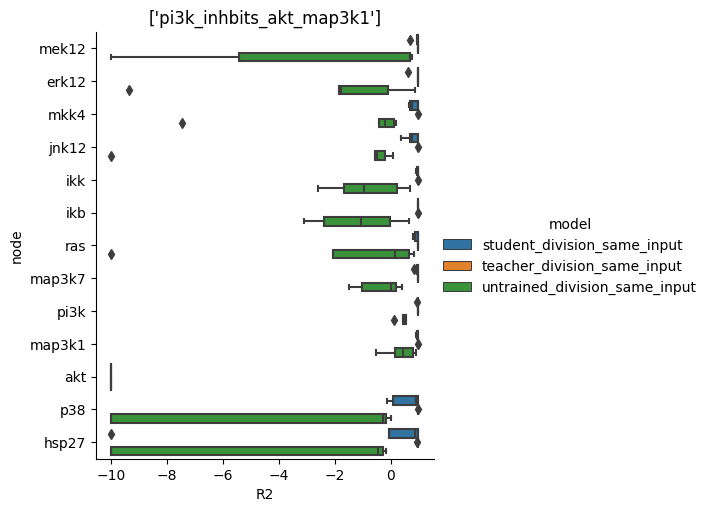

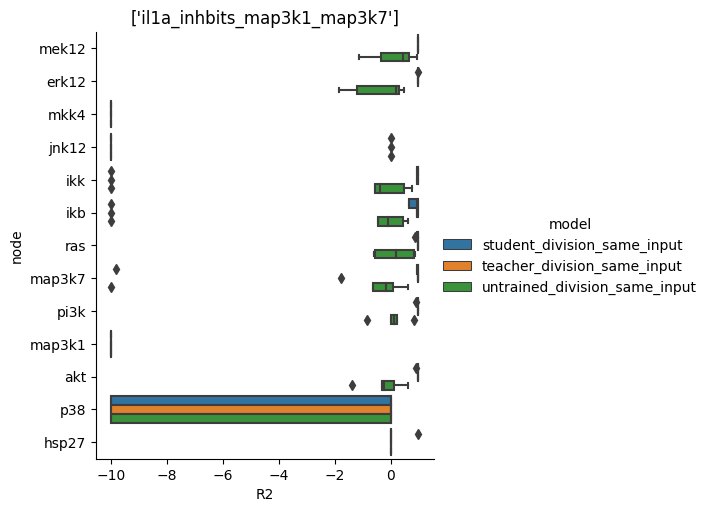

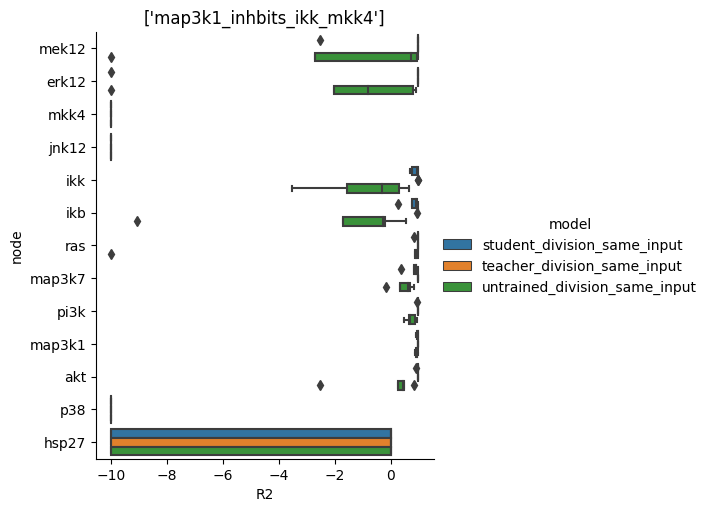

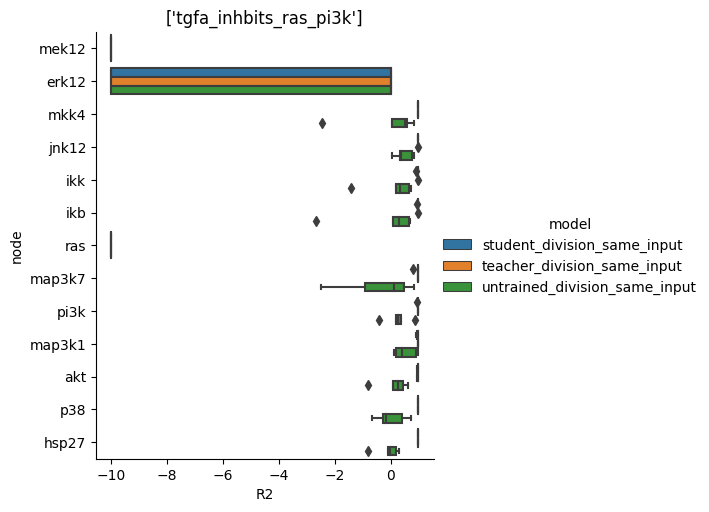

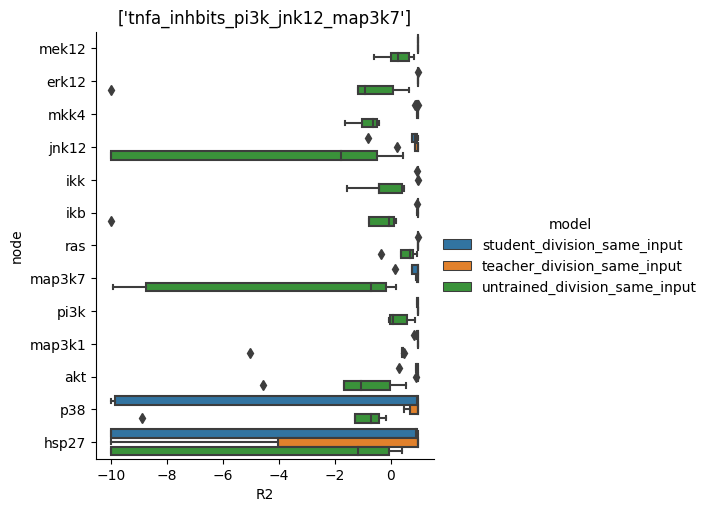

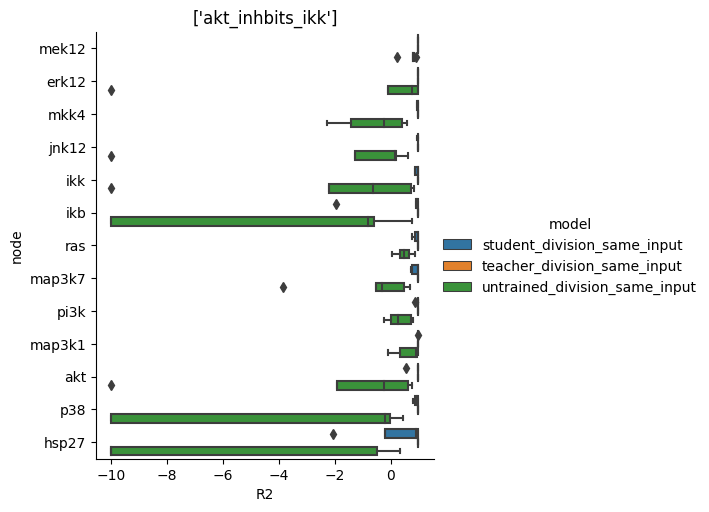

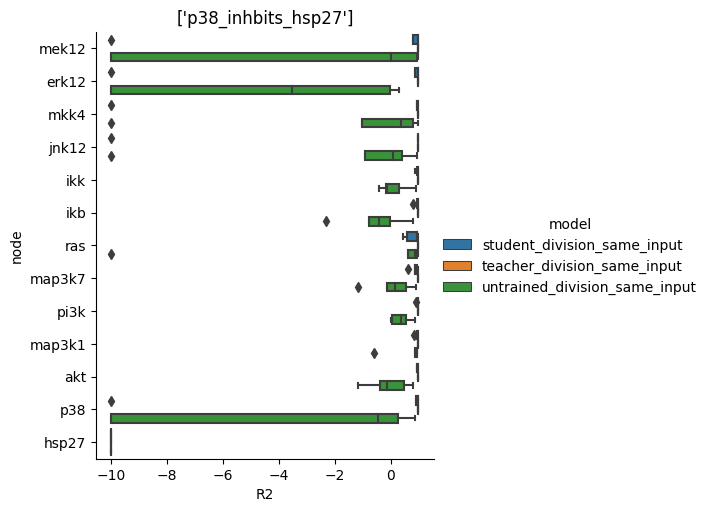

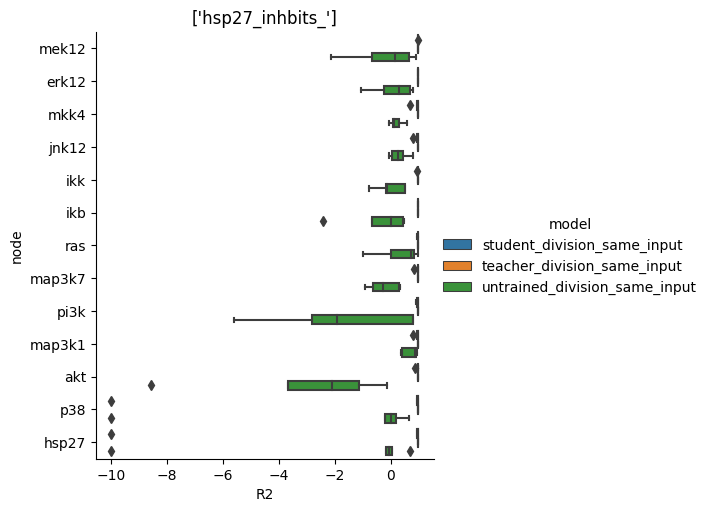

In [46]:
for n in plt_data["inhibited_node"].unique():
    temp = plt_data[plt_data["inhibited_node"]==n]
    temp.loc[temp["R2"]<-10, "R2"] = -10
    sns.catplot(data=temp, y="node", x="R2", kind="box", hue="model")
    plt.title(temp["Inhibited: "].unique())
    plt.show()

(-5.817388867380908e+56, 100000000.0)

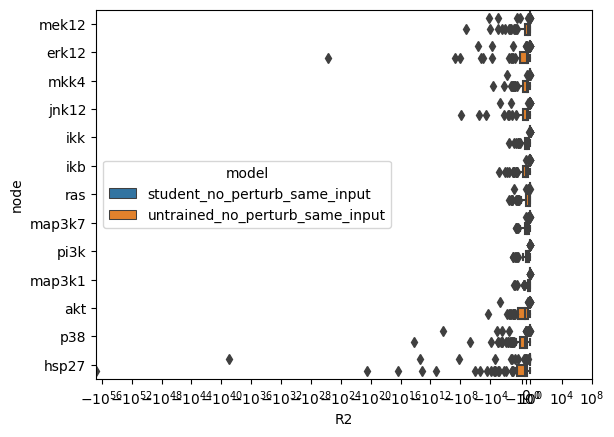

In [33]:
# In unperturbed data, there is no inhibition so all settings are the same (inhibited node doesn't matter)
plt_data = unperturb_R2[["same" in m for m in unperturb_R2["model"]]]
plt_data = plt_data.melt(id_vars=["setting", "repeat", "model", "inhibited_node"], var_name="node", value_name="R2")
sns.boxplot(data = plt_data, y="node", x="R2", hue="model")
plt.xscale("symlog")
plt.xlim(None, 1e8)

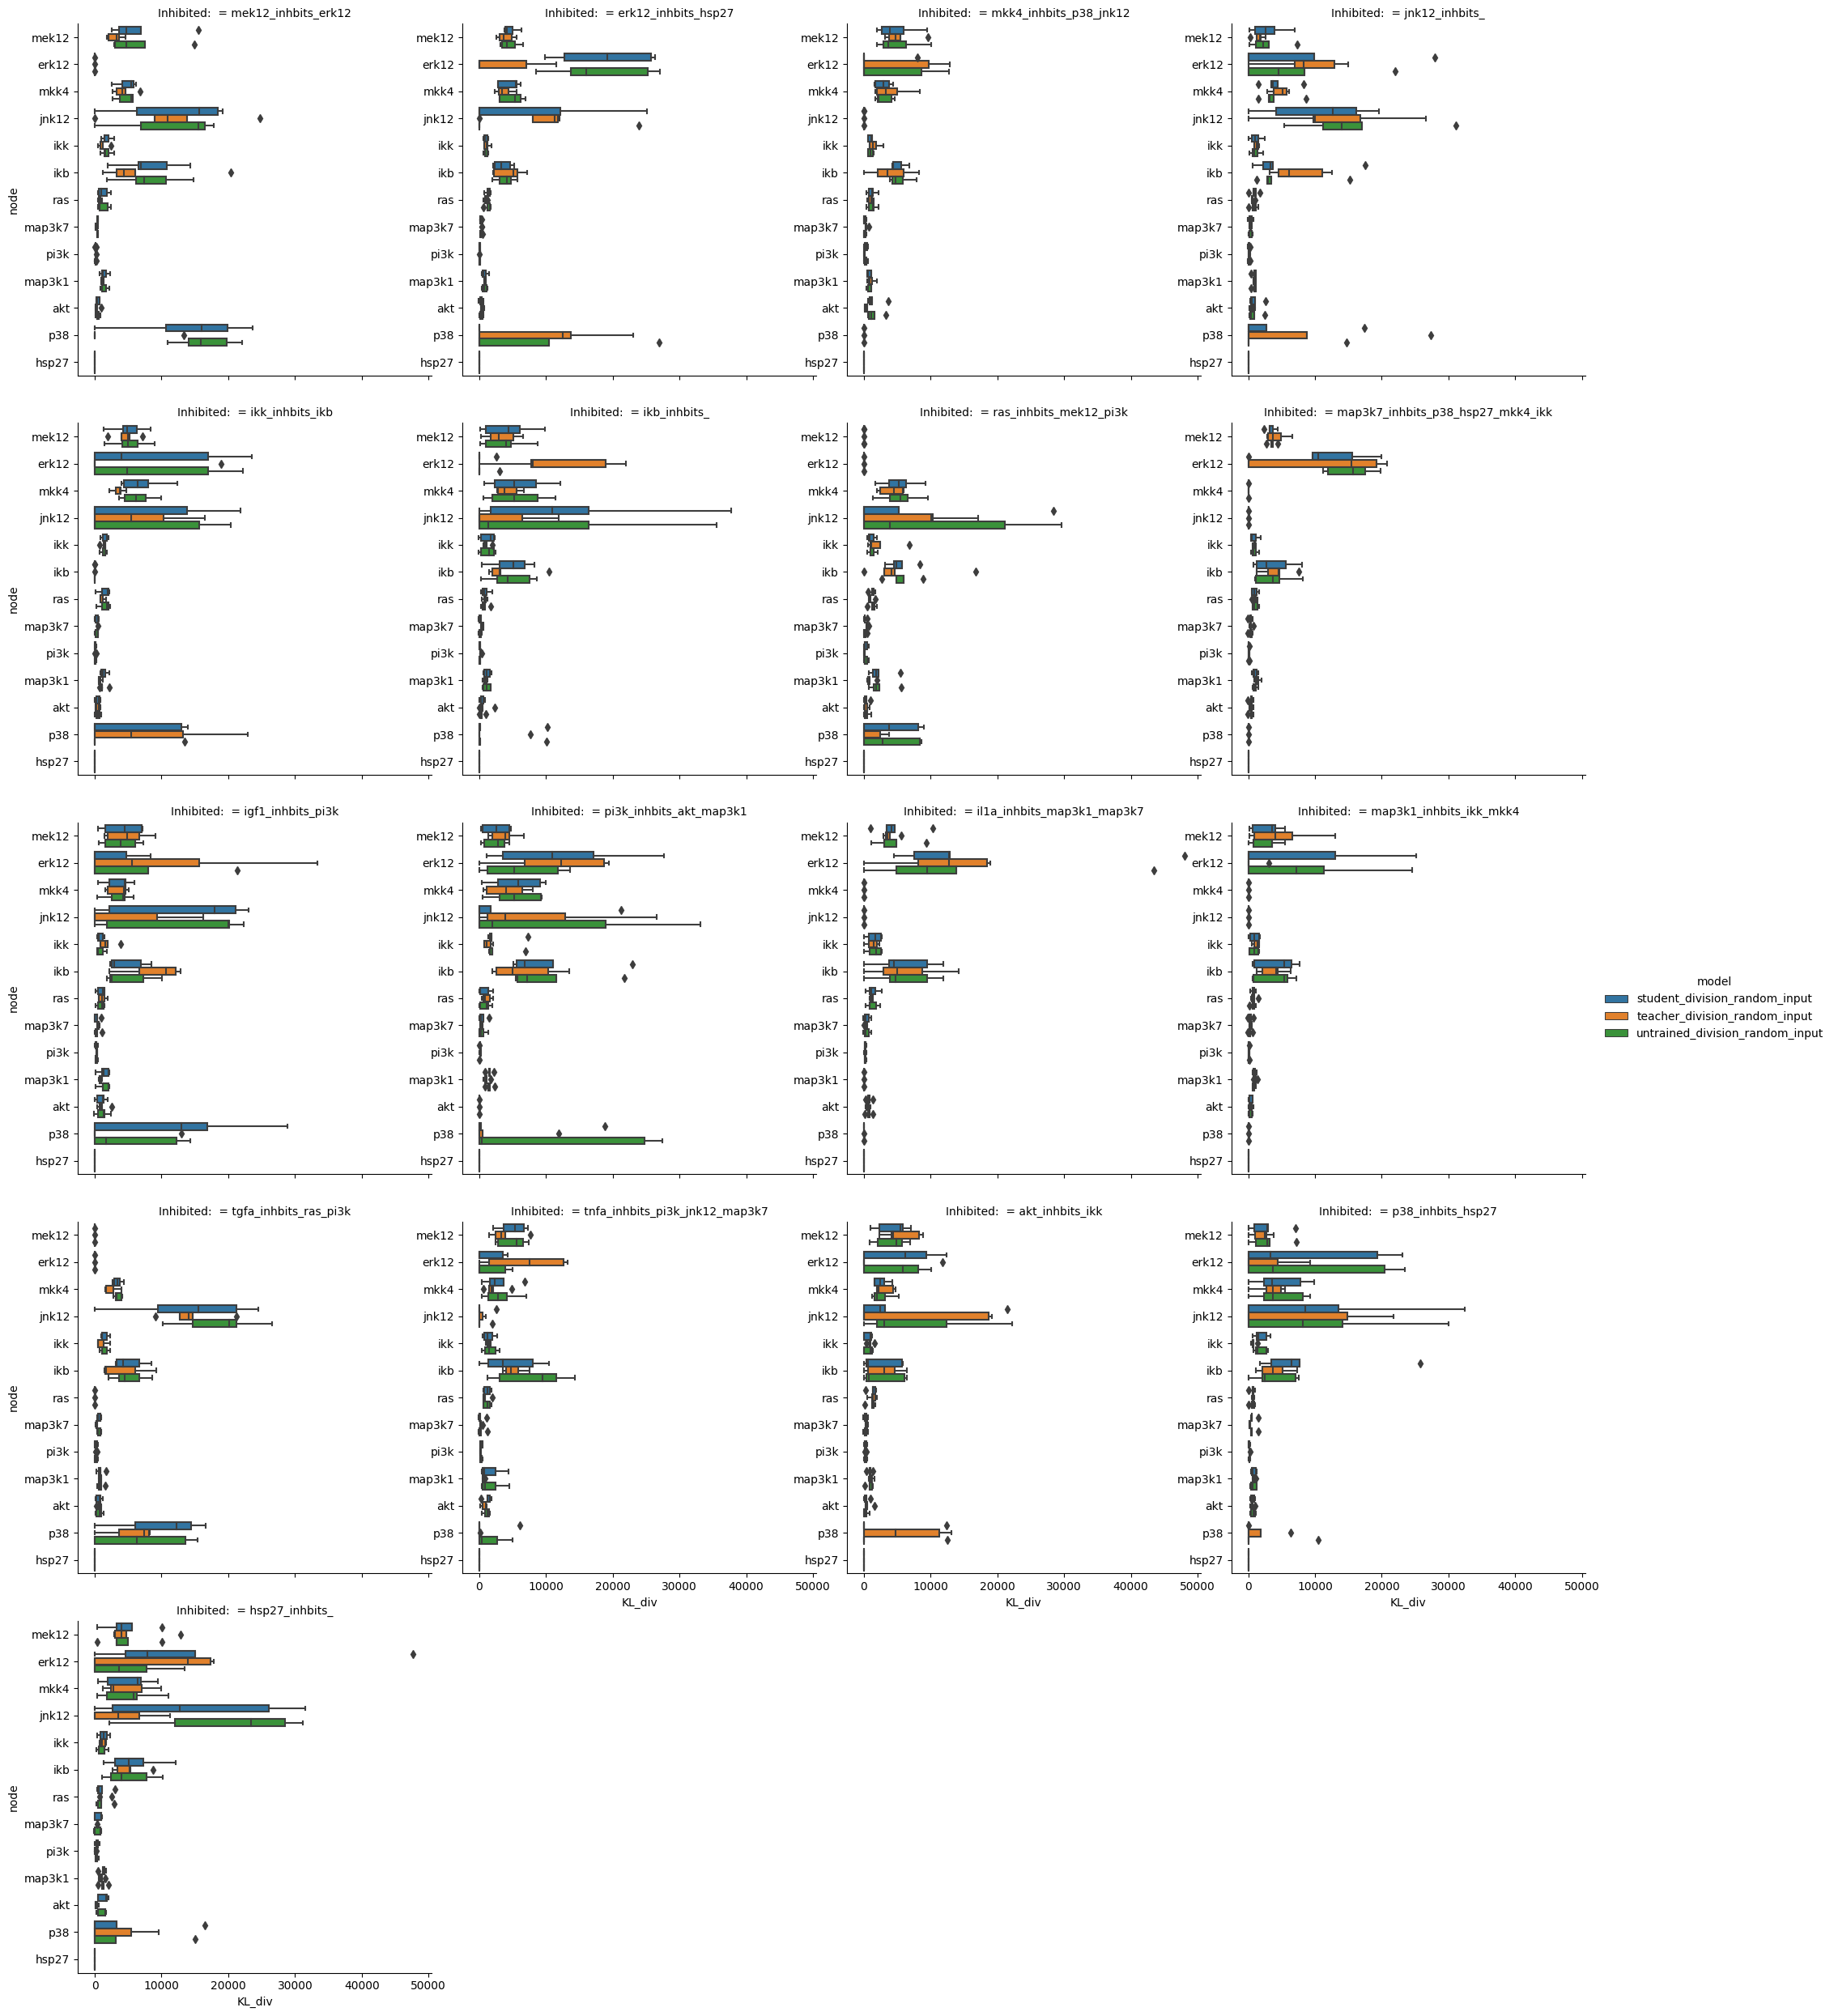

In [22]:
plt_data = perturb_KL[["random" in m for m in perturb_KL["model"]]]
plt_data = plt_data.melt(id_vars=["setting", "repeat", "model", "inhibited_node"], var_name="node", value_name="KL_div")
plt_data["Inhibited: "] = plt_data["inhibited_node"].map(child_dict)
g = sns.catplot(data=plt_data, y="node", x="KL_div", col="Inhibited: ", col_wrap=4, kind="box", hue="model")
for ax in g.axes.flatten():
    ax.tick_params(labelleft=True)

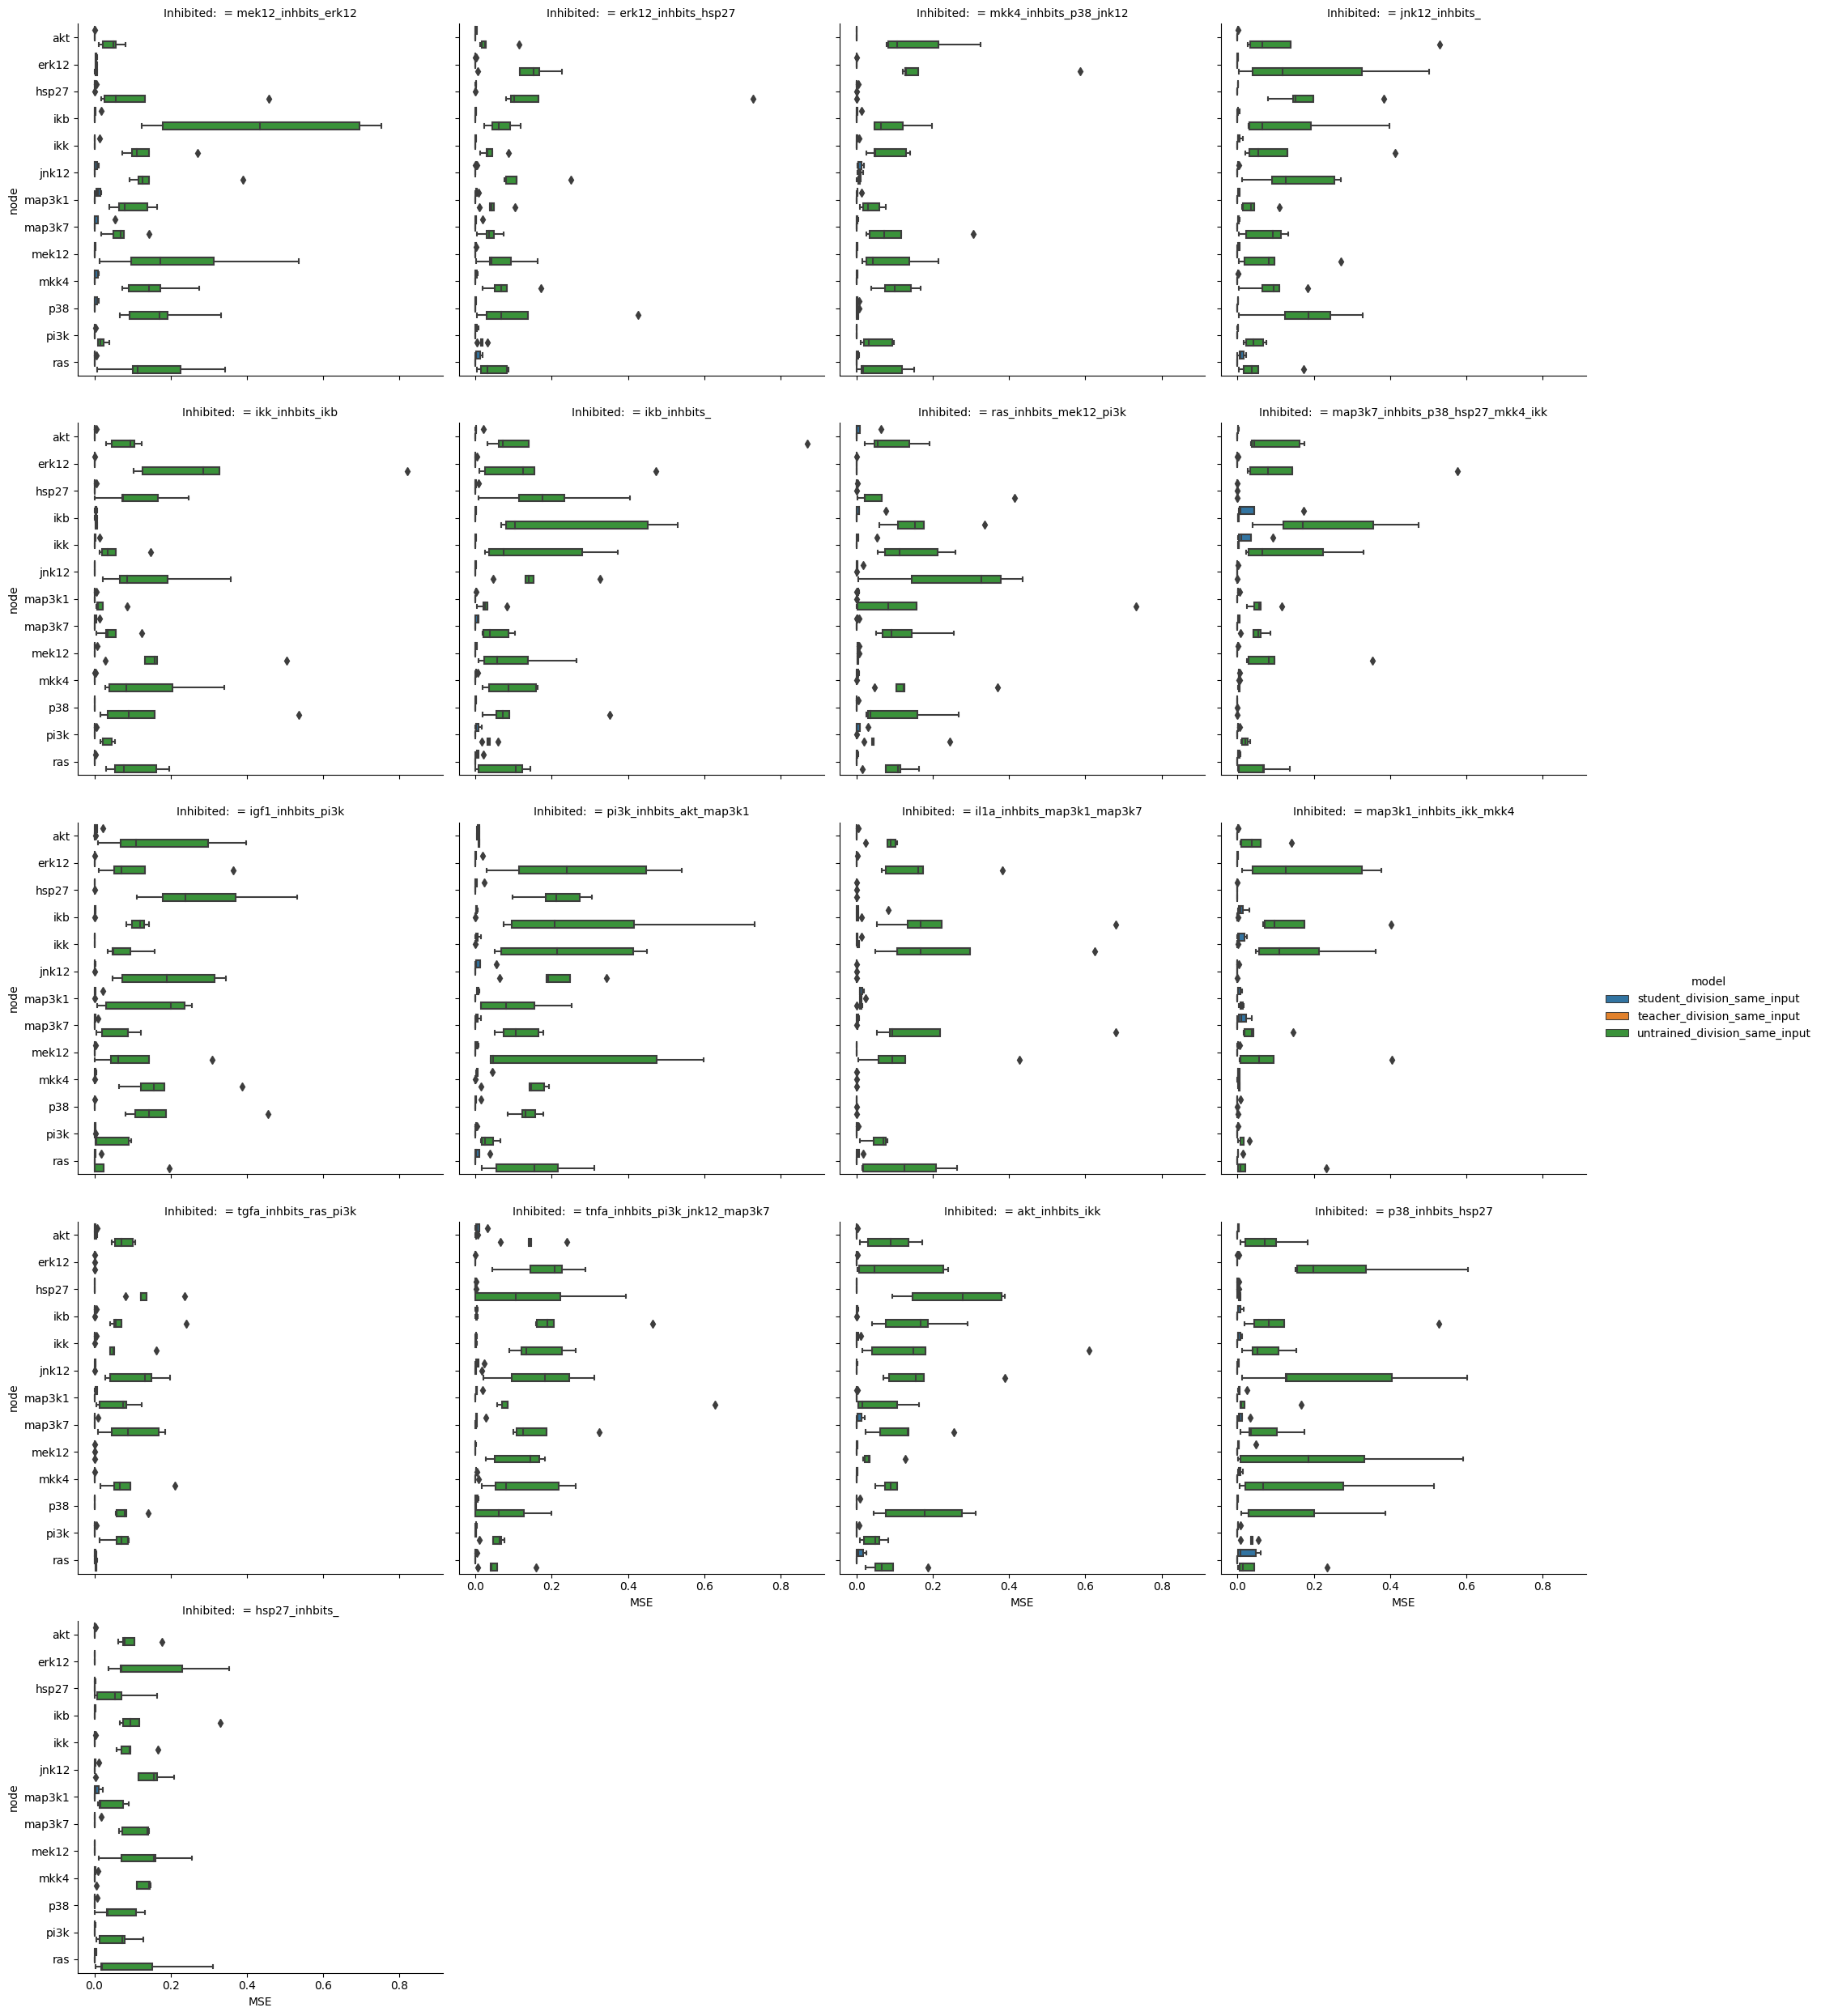

In [23]:
plt_data = perturb_MSE[["same" in m for m in perturb_MSE["model"]]]
plt_data = plt_data.melt(id_vars=["setting", "repeat", "model", "inhibited_node"], var_name="node", value_name="MSE")
plt_data["Inhibited: "] = plt_data["inhibited_node"].map(child_dict)
g = sns.catplot(data=plt_data, y="node", x="MSE", col="Inhibited: ", col_wrap=4, kind="box", hue="model")

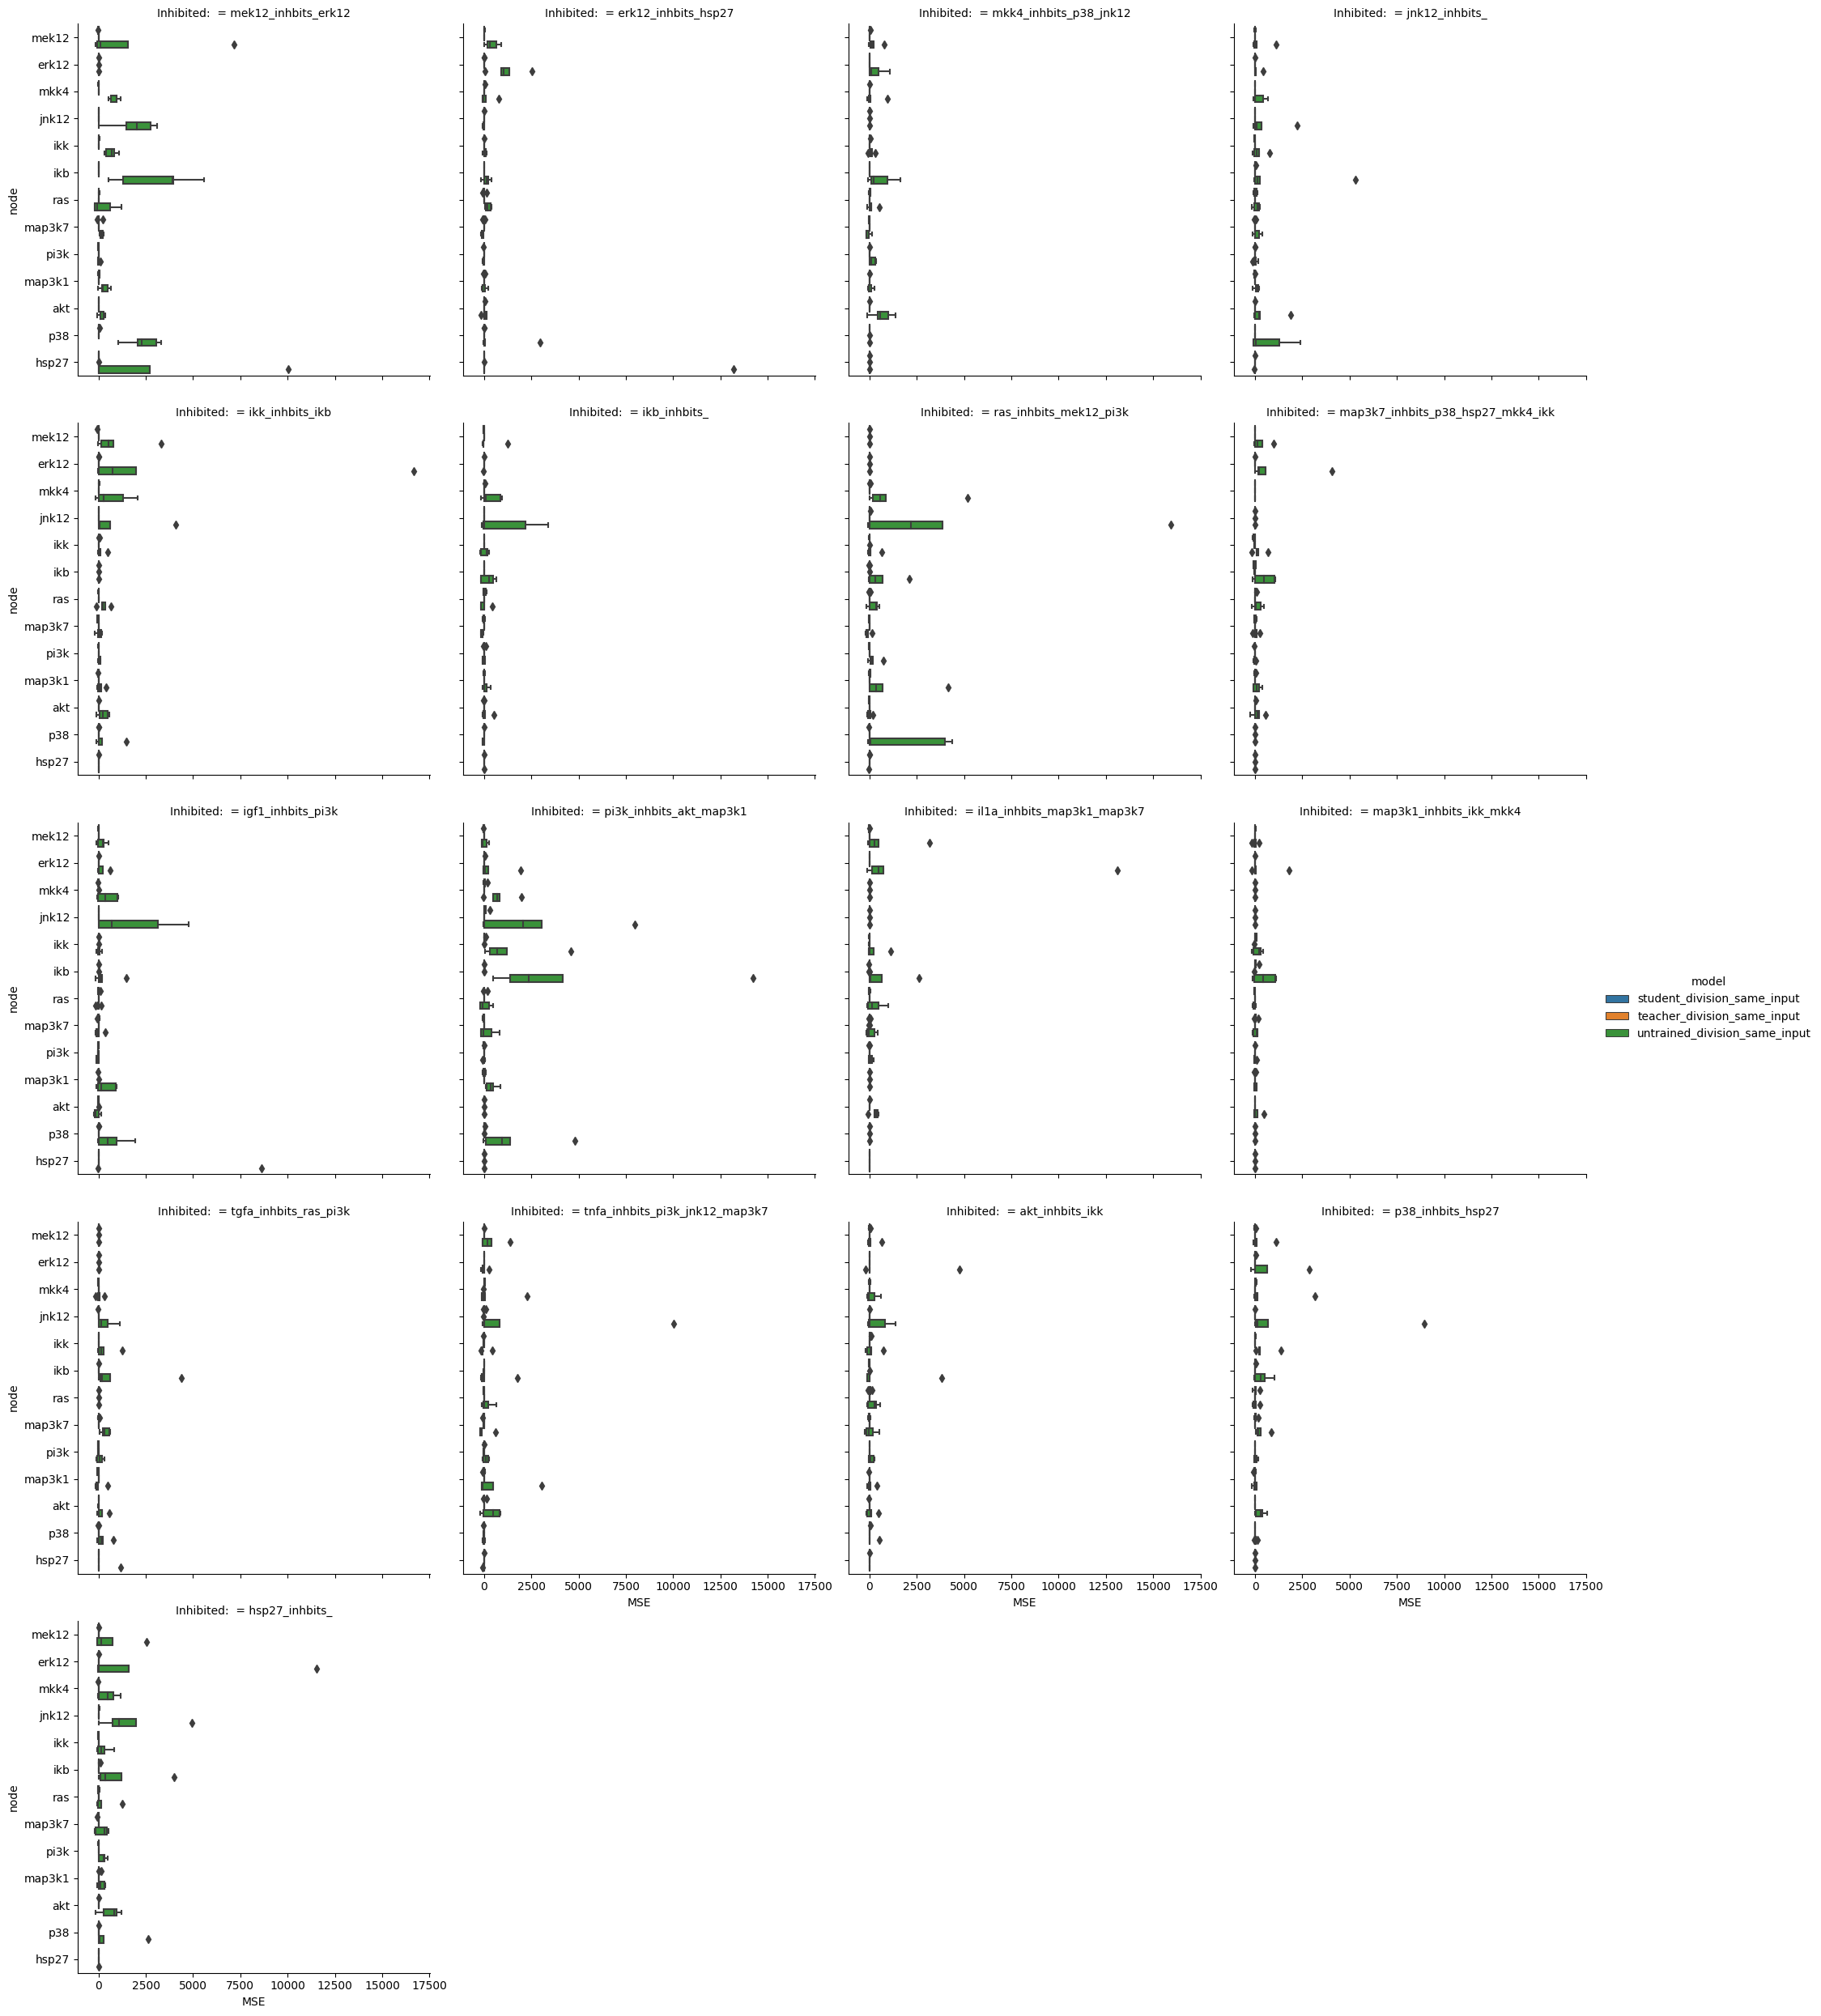

In [24]:
plt_data = perturb_KL[["same" in m for m in perturb_KL["model"]]]
plt_data = plt_data.melt(id_vars=["setting", "repeat", "model", "inhibited_node"], var_name="node", value_name="MSE")
plt_data["Inhibited: "] = plt_data["inhibited_node"].map(child_dict)
g = sns.catplot(data=plt_data, y="node", x="MSE", col="Inhibited: ", col_wrap=4, kind="box", hue="model")

<AxesSubplot:xlabel='KL_div', ylabel='node'>

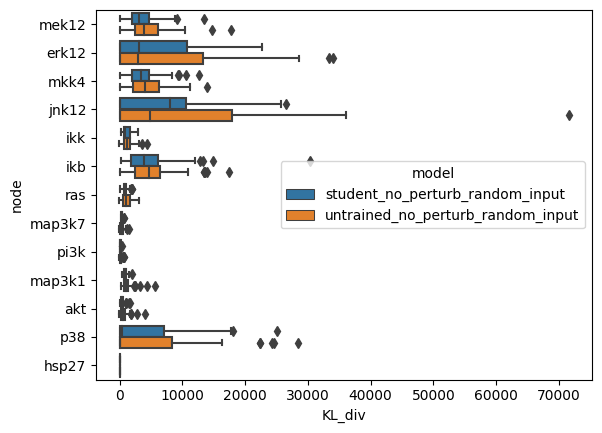

In [25]:
# In unperturbed data, there is no inhibition so all settings are the same (inhibited node doesn't matter)
plt_data = unperturb_KL[["random" in m for m in unperturb_KL["model"]]]
plt_data = plt_data.melt(id_vars=["setting", "repeat", "model", "inhibited_node"], var_name="node", value_name="KL_div")
sns.boxplot(data=plt_data, y="node", x="KL_div", hue="model")

<AxesSubplot:xlabel='MSE', ylabel='node'>

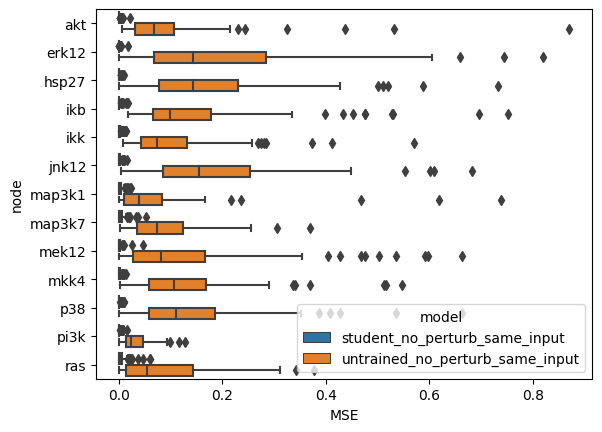

In [26]:
# In unperturbed data, there is no inhibition so all settings are the same (inhibited node doesn't matter)
plt_data = unperturb_MSE[["same" in m for m in unperturb_MSE["model"]]]
plt_data = plt_data.melt(id_vars=["setting", "repeat", "model", "inhibited_node"], var_name="node", value_name="MSE")
sns.boxplot(data=plt_data, y="node", x="MSE", hue="model")

In [27]:
true = perturb_data[perturb_data["model"]=="teacher_k_inhibition_true"]
true = true[true["setting"]==0.0]
true = true[true["repeat"]==0.0]
temp = perturb_data[perturb_data["model"]=="untrained_division_random_input"]
temp = temp[temp["setting"]==0.0]
temp = temp[temp["repeat"]==0.0]

In [28]:
for m in output_markers:
    print(m, r2_score(true[m], temp[m]))

mek12 -1.2151667161986417
erk12 -5.825685432061689e+28
mkk4 -0.8699859443983209
jnk12 -1.0442694649823538
ikk -1.720611692880294
ikb -10.090487374733625
ras -2.796788849651703
map3k7 -1.8333632594448916
pi3k -2.237599214257044
map3k1 -0.7410609632472529
akt -4.217187051545545
p38 -0.9239619638939436
hsp27 -1.042908628468059


In [29]:
temp

,model,mek12,erk12,mkk4,jnk12,ikk,ikb,ras,map3k7,pi3k,map3k1,akt,p38,hsp27,setting,repeat,node
0,untrained_division_random_input,9.648995e-01,9.984376e-02,5.945218e-04,6.213186e-15,0.886733,1.055886e-01,9.915239e-01,0.919135,1.000000,0.082271,0.991286,1.888830e-11,2.244381e-36,0.0,0.0,mek12
1,untrained_division_random_input,9.572327e-01,9.983667e-02,2.879912e-01,1.100168e-01,0.961587,1.635732e-01,9.609260e-01,0.944353,0.999879,0.799161,0.991282,1.951801e-01,8.668772e-03,0.0,0.0,mek12
2,untrained_division_random_input,9.593140e-01,9.983863e-02,1.305849e-02,1.874011e-08,0.889920,1.077176e-01,9.685860e-01,0.926933,0.999996,0.241207,0.991286,2.127153e-06,1.601350e-19,0.0,0.0,mek12
3,untrained_division_random_input,9.613416e-01,9.984052e-02,5.859670e-02,3.305998e-05,0.722306,3.186158e-02,9.764812e-01,0.628069,0.999845,0.438158,0.991281,2.076605e-04,6.953155e-13,0.0,0.0,mek12
4,untrained_division_random_input,9.658776e-01,9.984464e-02,5.234599e-10,2.240022e-46,0.000079,6.947294e-27,9.959607e-01,0.025433,0.999990,0.008122,0.991286,6.118794e-50,8.711854e-165,0.0,0.0,mek12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,untrained_division_random_input,9.634919e-01,9.984249e-02,5.386640e-05,1.038351e-19,0.832405,7.375505e-02,9.853768e-01,0.797567,0.999994,0.036293,0.991286,2.022199e-15,1.273219e-49,0.0,0.0,mek12
996,untrained_division_random_input,3.227446e-89,0.000000e+00,2.053389e-18,1.173321e-79,0.258778,5.505966e-05,1.910906e-14,0.348530,0.086361,0.000001,0.005257,5.281527e-69,0.000000e+00,0.0,0.0,mek12
997,untrained_division_random_input,1.689380e-19,2.289457e-103,1.917238e-06,2.349001e-26,0.408692,9.474041e-04,8.201683e-04,0.431240,0.032912,0.013292,0.000104,6.324416e-23,2.239481e-163,0.0,0.0,mek12
998,untrained_division_random_input,9.508859e-01,9.983052e-02,3.918132e-04,9.018120e-16,0.892096,1.091879e-01,9.399063e-01,0.934900,0.999949,0.071084,0.991284,3.950749e-12,1.213054e-38,0.0,0.0,mek12


In [30]:
r2_score(true, temp)

ValueError: could not convert string to float: 'teacher_k_inhibition_true'

In [ ]:
perturb_R2[perturb_R2["model"]=="untrained_division_random_input"]